<a href="https://colab.research.google.com/github/HernanDL/Noise-Cancellation-Using-GenAI/blob/main/U_Net_Style_Frequency_Domain_Noise_Cancellation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Frequency-Domain Prediction with U-Net Style Model
To handle a wider range of frequencies and make the model more flexible, let's shift our approach and predict in the frequency domain (using a spectrogram representation of the signal). Specifically, we can use a U-Net style model to process the spectrogram and learn to predict the inverse signal in the frequency domain.

##Why U-Net?
U-Net is a powerful model for tasks like denoising, where capturing both local and global features is important. By working in the frequency domain, the model can directly learn the inverse signal at different frequency bands.
##Steps:
Convert the waveform to a Mel-spectrogram to work in the frequency domain.

1.   Convert the waveform to a Mel-spectrogram to work in the frequency domain.
2.   U-Net architecture: Use a U-Net-like model to predict the inverse of the spectrogram.
3.   Inverse the predicted spectrogram back to waveform and combine it with the input signal for cancellation.

##Key Differences from the Previous Approach:
###Frequency-Domain Prediction:

We’re working with Mel-spectrograms instead of raw waveforms. This allows the model to capture both low and high-frequency components effectively.
U-Net Architecture:

U-Net is well-suited for tasks where local and global context matter, and it can learn to predict the inverse spectrogram efficiently.
Better Handling of High-Frequency Components:

By predicting in the frequency domain, the model can better handle high-frequency components that are hard to capture in the time domain.
Residual Noise Visualization:

After prediction, the combined waveform is evaluated to see how much noise remains after destructive interference, and the residual noise is plotted.

###Why This Approach Might Work Better:
High-frequency handling: Since we’re working in the frequency domain, the model has better visibility into different frequency bands, allowing for more accurate predictions across the spectrum.
U-Net's multi-scale learning: The U-Net architecture is designed to capture both local (short-term) and global (long-term) dependencies, which is crucial for learning the patterns of both high and low frequencies in noise cancellation tasks.

###Flexible Architecture: U-Net's flexibility makes it a great candidate for tasks that involve learning complex mappings, such as noise cancellation in the frequency domain.

###Next Steps:
1) Monitor the Loss: Track how the loss decreases during training and check if the predictions improve with more epochs.

2) Tune the Model: You can experiment with adding more layers or units to the U-Net if needed, depending on how well the model captures the cancelling signal.

3) Experiment with Other Spectrograms: Try STFT (Short-Time Fourier Transform) or other types of spectrograms to see if they work better than Mel-spectrograms for your specific data.

In [4]:
# 1. Install Dependencies
!pip install librosa matplotlib tensorflow

# 2. Import Libraries
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# 3. Load and Downsample the Input WAV File
from google.colab import files
uploaded = files.upload()

Saving 1-9887-A-49.wav to 1-9887-A-49.wav


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.0011 - learning_rate: 0.0010
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step - loss: 0.9855 - learning_rate: 0.0010
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 0.9780 - learning_rate: 0.0010
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - loss: 0.9736 - learning_rate: 0.0010
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step - loss: 0.9710 - learning_rate: 0.0010
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - loss: 0.9688 - learning_rate: 0.0010
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - loss: 0.9670 - learning_rate: 0.0010
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - loss: 0.9653 - learning_rate: 0.0010
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - loss: 0.9639 - learning_rate: 0.0010
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step - loss: 0.9625 - learning_rate: 0.0010
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step - loss: 0.9610 - learning_rate: 0.0010
Epoch 12/20
1/1 ━━━━━━

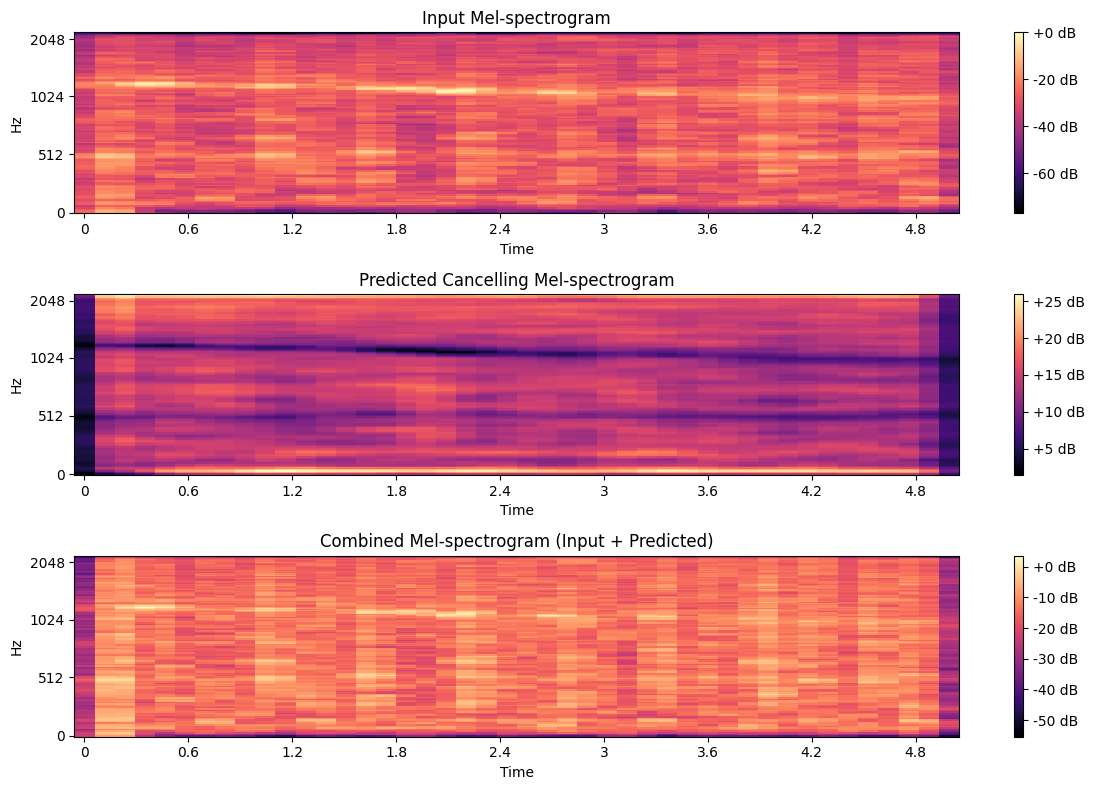

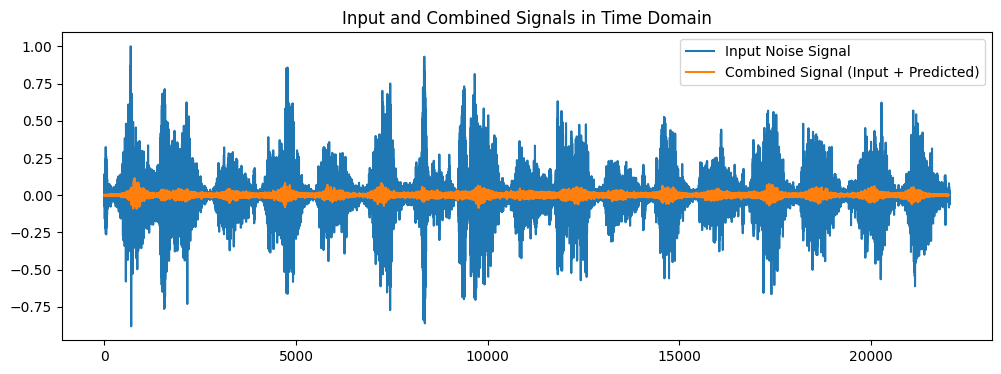

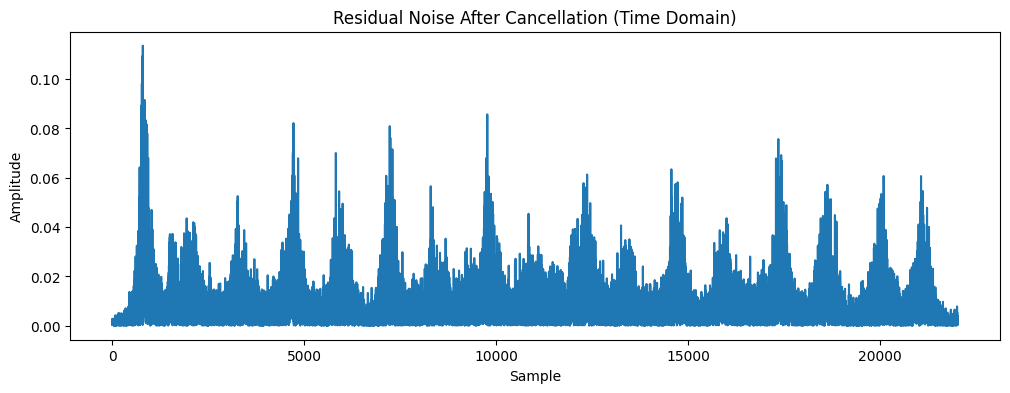

In [12]:
audio_path = list(uploaded.keys())[0]
y, sr = librosa.load(audio_path, sr=None)

# Downsample the input signal
target_sr = sr // 10  # Downsample by a factor of 10
y_downsampled = librosa.resample(y, orig_sr=sr, target_sr=target_sr)

# Normalize the input signal between -1 and 1
y_downsampled = y_downsampled / np.max(np.abs(y_downsampled))

# 4. Convert the Input Signal to Mel-Spectrogram
def waveform_to_spectrogram(y, sr, n_fft=2048, hop_length=512):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)  # Convert to decibel (dB) scale
    return S_db

# Generate the Mel-spectrogram of the input signal
x_train_spectrogram = waveform_to_spectrogram(y_downsampled, target_sr)
# The ideal output is the inverse (negative) of the input Mel-spectrogram
y_train_spectrogram = -x_train_spectrogram

# Reshape for training
x_train_spectrogram = x_train_spectrogram.T.reshape((1, x_train_spectrogram.shape[1], x_train_spectrogram.shape[0], 1))
y_train_spectrogram = y_train_spectrogram.T.reshape((1, y_train_spectrogram.shape[1], y_train_spectrogram.shape[0], 1))

# 5. Build a U-Net Style Model with Batch Normalization and Increased Capacity
def build_unet_model(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D((2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = tf.keras.layers.BatchNormalization()(conv2)
    pool2 = tf.keras.layers.MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = tf.keras.layers.BatchNormalization()(conv3)

    # Decoder
    up1 = tf.keras.layers.UpSampling2D((2, 2))(conv3)
    merge1 = tf.keras.layers.Concatenate()([up1, conv2])
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)
    conv4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = tf.keras.layers.BatchNormalization()(conv4)

    up2 = tf.keras.layers.UpSampling2D((2, 2))(conv4)
    merge2 = tf.keras.layers.Concatenate()([up2, conv1])
    conv5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge2)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)
    conv5 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = tf.keras.layers.BatchNormalization()(conv5)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='linear')(conv5)

    model = tf.keras.Model(inputs, outputs)
    return model

# Build the U-Net model with increased capacity and batch normalization
model = build_unet_model(input_shape=(x_train_spectrogram.shape[1], x_train_spectrogram.shape[2], 1))

def spectral_convergence_loss(y_true, y_pred):
    return tf.norm(y_true - y_pred, ord='fro', axis=[-2, -1]) / (tf.norm(y_true, ord='fro', axis=[-2, -1]) + 1e-8)

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss=spectral_convergence_loss)

# Learning rate scheduler (more aggressive)
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1
)

# 6. Train the Model with RMSProp, gradient clipping, and Learning Rate Scheduler
history = model.fit(x_train_spectrogram, y_train_spectrogram, epochs=20, batch_size=1, callbacks=[lr_scheduler])

# 7. Make Predictions and Combine Input with Predicted Output
predicted_output_spectrogram = model.predict(x_train_spectrogram)

# Convert the predicted spectrogram back to the original format
predicted_output_spectrogram = predicted_output_spectrogram.reshape(x_train_spectrogram.shape[1], x_train_spectrogram.shape[2]).T

# Combine the input and predicted output spectrograms to simulate destructive interference
combined_spectrogram = x_train_spectrogram[0, :, :, 0].T + predicted_output_spectrogram

# 8. Plot the Input, Predicted, and Combined Spectrograms
plt.figure(figsize=(12, 8))

# Plot the input spectrogram
plt.subplot(3, 1, 1)
librosa.display.specshow(x_train_spectrogram[0, :, :, 0].T, sr=target_sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Input Mel-spectrogram')

# Plot the predicted cancelling spectrogram
plt.subplot(3, 1, 2)
librosa.display.specshow(predicted_output_spectrogram, sr=target_sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Predicted Cancelling Mel-spectrogram')

# Plot the combined spectrogram (should be close to zero)
plt.subplot(3, 1, 3)
librosa.display.specshow(combined_spectrogram, sr=target_sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Combined Mel-spectrogram (Input + Predicted)')

plt.tight_layout()
plt.show()

# 9. Convert the Combined Spectrogram back to the Time Domain (Waveform)
def spectrogram_to_waveform(S_db, sr, n_fft=2048, hop_length=512):
    S = librosa.db_to_power(S_db)  # Convert back to power spectrogram
    return librosa.feature.inverse.mel_to_audio(S, sr=sr, n_fft=n_fft, hop_length=hop_length)

combined_waveform = spectrogram_to_waveform(combined_spectrogram, target_sr)

# Plot the input and predicted waveform combined
plt.figure(figsize=(12, 4))
plt.plot(y_downsampled, label='Input Noise Signal')
plt.plot(combined_waveform, label='Combined Signal (Input + Predicted)')
plt.legend()
plt.title('Input and Combined Signals in Time Domain')
plt.show()

# Plot residual noise in the time domain
plt.figure(figsize=(12, 4))
plt.plot(np.abs(combined_waveform))
plt.title('Residual Noise After Cancellation (Time Domain)')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.show()



### **Understanding the Mel-Spectrogram**:
A **Mel-spectrogram** is a representation of audio where:
- The **x-axis** represents time.
- The **y-axis** represents the Mel-scaled frequencies (human ear perception).
- The **color intensity** represents the amplitude (magnitude of the frequency components), usually expressed in **decibels (dB)**.

#### **Key Components of a Mel-Spectrogram**:
1. **Frequency (y-axis)**:
   - **Lower frequencies** (e.g., bass sounds) appear at the bottom.
   - **Higher frequencies** (e.g., treble) appear at the top.
   
2. **Time (x-axis)**:
   - The signal progresses from left to right.
   
3. **Amplitude (color intensity)**:
   - **Brighter areas** represent higher amplitudes (louder sounds).
   - **Darker areas** represent lower amplitudes (quieter sounds).

#### **Decibel (dB) Scale**:
- The color bar on the right of the spectrogram is in **dB**. The dB scale represents the amplitude of the frequency components:
  - A higher dB value (e.g., **0 dB**) indicates louder sounds.
  - Lower dB values (e.g., **-80 dB**) represent quieter or near-silence components.

#### **Interpreting the Combined Mel-Spectrogram (Input + Predicted)**:
The combined Mel-spectrogram shows the **input signal** added to the **predicted signal**. If the noise cancellation is working correctly:
- **Good Cancellation**: The combined spectrogram should show a reduction in amplitude across frequencies, meaning the input and predicted signals are canceling each other out.
- **Visual Cue**: You should see much **darker regions** in the combined spectrogram compared to the input, as the destructive interference reduces the amplitude.
  - Ideally, the combined spectrogram will have large areas of near-zero dB (dark colors) because the cancellation is successful.
  
#### What to Expect for Good Noise Cancellation:
- **Reduction in Brightness**: The combined spectrogram should be **darker** than the input Mel-spectrogram because the amplitude has been reduced.
- **Uniform Cancellation**: Look for dark areas across a **broad range of frequencies**. If cancellation is only happening at certain frequencies, the spectrogram will still have bright patches in uncanceled frequency bands.
  
In the **time domain plot** (e.g., the combined waveform), good cancellation means the waveform should approach zero amplitude, indicating that the noise signal has been successfully canceled.

### Example:

- **Input Mel-Spectrogram**: You'll see brighter areas showing loud frequency components across the spectrogram.
- **Predicted Mel-Spectrogram**: It will mirror the input spectrogram in terms of frequency content, but with an inverted phase.
- **Combined Mel-Spectrogram**: For successful cancellation, you should see much **darker regions** in the combined spectrogram, indicating that the loud frequency components from the input and predicted signals are canceling each other out.

